In [30]:
import pandas as pd
import numpy as np
file_path = r'paper_data.xlsx'
data = pd.read_excel(file_path)
# drop the "index" column
data = data.drop('Index', axis=1)

features = data.columns
numeric_features = ['Age','Years of Work Experience','Years of Work Experience at Current Institution', 'Institution Level', 'Number of Children Under 12',
                    'First Degree', 'Highest Degree', 'Monthly Night Shift Frequency', 'Monthly Take-home Income',
                    'Number of Specialist Trainings/Continuing Education Attended', 'Average Number of Clinical Teaching/Training Activities Participated in per Year', 
                    'Degree of Application of Specialist Skills in Subsequent Clinical Practice']
categorical_features = ['Gender', 'Job Title', 'Position', 
            'Employment Type',  
            'Whether Obtained Specialist Qualification Certificate and the Specialist Field',
            'Whether Working in a Specialist Nursing Outpatient Clinic', 
            'Whether Undertaken Research Projects in the Past Three Years', 'Whether Role Stress is High', 
            'Whether Empathy Level is High', 'Whether Level of Happiness is High', 'Whether Satisfaction with Performance Distribution is High']
target = 'In Your Current Medical Institution, Your Inclination to Change Position in the Next 1-10 Years'
# ensure numeric_features is a subset of features
assert(all(elem in features for elem in numeric_features))
# ensure categorical_features is a subset of features
assert(all(elem in features for elem in categorical_features))
# ensure each feature is either in numeric_features or categorical_features, or it is the target
assert(all(elem in numeric_features or elem in categorical_features or elem == target for elem in features))
# ensure there is no duplicates among the three categories
assert(all(elem not in numeric_features for elem in categorical_features))
assert(all(elem not in categorical_features for elem in numeric_features))
assert(target not in numeric_features + categorical_features)

# X is all but target
X = data[numeric_features + categorical_features]
y = data[target]

# Get the feature indices for preprocessing pipeline
numeric_feature_mask = np.isin(X.columns.to_numpy(), np.array(numeric_features))
numeric_feature_indices = np.nonzero(numeric_feature_mask)[0]
categorical_feature_mask = np.isin(X.columns.to_numpy(), np.array(categorical_features))
categorical_feature_indices = np.nonzero(categorical_feature_mask)[0]
assert(len(numeric_feature_indices) == len(numeric_features))
assert(len(categorical_feature_indices) == len(categorical_features))
print(f'Features: {X.columns}')
print(f'Numeric: {numeric_features}')
print(f'Categorical: {categorical_features}')
print(f'Numeric Feature Indices: {numeric_feature_indices}')
print(f'Categorical Feature Indices: {categorical_feature_indices}')




Features: Index(['Age', 'Years of Work Experience',
       'Years of Work Experience at Current Institution', 'Institution Level',
       'Number of Children Under 12', 'First Degree', 'Highest Degree',
       'Monthly Night Shift Frequency', 'Monthly Take-home Income',
       'Number of Specialist Trainings/Continuing Education Attended',
       'Average Number of Clinical Teaching/Training Activities Participated in per Year',
       'Degree of Application of Specialist Skills in Subsequent Clinical Practice',
       'Gender', 'Job Title', 'Position', 'Employment Type',
       'Whether Obtained Specialist Qualification Certificate and the Specialist Field',
       'Whether Working in a Specialist Nursing Outpatient Clinic',
       'Whether Undertaken Research Projects in the Past Three Years',
       'Whether Role Stress is High', 'Whether Empathy Level is High',
       'Whether Level of Happiness is High',
       'Whether Satisfaction with Performance Distribution is High'],
      d

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
# print(numeric_feature_indices)
# print(categorical_feature_indices)

preproc_scale_onehot = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
preproc_scale = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)
preproc_onehot = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
feature_selection = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))
smote = SMOTE()
# X_preprocessed = preprocessor.fit_transform(X)
# print(X_preprocessed)


In [33]:
import pygame
import time
# Initialize pygame's mixer module
pygame.mixer.init()

# Load a sound file (you need to provide a path to a WAV or OGG file)
sound = pygame.mixer.Sound('ok.wav')

# Set the volume (0.0 to 1.0)
sound.set_volume(0.5)  # Set to 50% volume
def play_finished_hint():
    sound.play()
    time.sleep(0.5)
play_finished_hint()

In [34]:
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna import trial as optuna_trial
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
# preproc_steps_scale_select_SMOTE = ImbPipeline(steps=[
#     ('preprocessor', preproc_scale),
#     ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))),
#     ('smote', SMOTE())
# ])

# just for intellisense purposes
suggest_float = 'suggest_float'
suggest_int = 'suggest_int'
suggest_categorical = 'suggest_categorical'

metric = 'roc_auc'
optuna.logging.set_verbosity(optuna.logging.ERROR)
def cross_validate_model(model_class, hyperparameters, n_trials = 100): # [hyperparameter_name, functionname, (function args)
    def objective(trial: optuna_trial.Trial):
        # Define the pipeline
        adopt_scalar = trial.suggest_categorical('Adopt StandardScalar for numeric features', [True, False])
        adopt_onehot = trial.suggest_categorical('Adopt OneHotEncoder for categorical features', [True, False])
        adopt_selection = trial.suggest_categorical('Adopt feature selection', [True, False])
        adopt_SMOTE = trial.suggest_categorical('Adopt oversampling using SMOTE', [True, False])
        # pipeline steps
        steps = []
        if adopt_scalar and adopt_onehot: steps.append(('onehot_and_scalar', preproc_scale_onehot))
        else:
            if adopt_scalar:
                assert(not adopt_onehot)
                steps.append(('scalar', preproc_scale))
            if adopt_onehot:
                assert(not adopt_scalar)
                steps.append(('onehot', preproc_onehot))
        if adopt_selection: steps.append(('selection', feature_selection))
        if adopt_SMOTE: steps.append(('smote', smote))
        model_args = {}
        for hyperparameter in hyperparameters:
            parameter_name, function_name, function_args = hyperparameter
            func = getattr(trial, function_name)
            function_kwargs = {'log': True} if function_name == suggest_float else {}
            if function_args[0] == "hidden_layer_sizes":
                model_args.update({parameter_name: (func(*function_args, **function_kwargs),)})
            else:
                model_args.update({parameter_name: func(*function_args, **function_kwargs)})
        model = model_class(**model_args)
        steps.append(('classifier', model))
        pipeline = ImbPipeline(steps=steps)
        # Perform cross-validation
        score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=10, scoring=metric)
        mean_score = score.mean()
        # print(f"score: {mean_score}")
        return mean_score
    
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))  # Use 'minimize' for regression tasks
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True, n_jobs=-1)  # Set the number of trials as needed
    trial = study.best_trial
    print(f'{model_class.__name__} Cross-Validation Performance:')
    print("Best trial:")
    print(f"  Value: {trial.value}")
    print("  Best hyperparameters:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

In [36]:
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 10, 1000]),
    ('max_depth', suggest_int, ['max_depth', 1, 30]),
    ('min_samples_split', suggest_int, ['min_samples_split', 2, 20]),
    ('min_samples_leaf', suggest_int, ['min_samples_leaf', 1, 10]),
    ('max_features', suggest_categorical, ['max_features', ['log2', 'sqrt']]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(RandomForestClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 62. Best value: 0.70819: 100%|██████████| 100/100 [02:14<00:00,  1.34s/it]


RandomForestClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7081896551724138
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: False
    Adopt oversampling using SMOTE: True
    n_estimators: 255
    max_depth: 10
    min_samples_split: 6
    min_samples_leaf: 1
    max_features: sqrt
    random_state: 42


In [37]:
import xgboost as xgb
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 50, 1000]),
    ('max_depth', suggest_int, ['max_depth', 3, 20]),
    ('learning_rate', suggest_float, ['learning_rate', 0.005, 0.2]),
    ('subsample', suggest_float, ['subsample', 0.5, 1.0]),
    ('colsample_bytree', suggest_float, ['colsample_bytree', 0.3, 1.0]),
    ('random_state', suggest_categorical, ['random_state', [42]])
    # ('tree_method', suggest_categorical, ['tree_method', ['hist']]),
    # ('device', suggest_categorical, ['device', ['cuda']]) # gpu is overkill for this task
    # ('gpu_id', suggest_categorical, ['gpu_id', [0]]) # depending on which GPU you want to use
]
cross_validate_model(xgb.XGBClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 67. Best value: 0.691011: 100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


XGBClassifier Cross-Validation Performance:
Best trial:
  Value: 0.6910105363984673
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: False
    Adopt oversampling using SMOTE: True
    n_estimators: 213
    max_depth: 13
    learning_rate: 0.00716073506310541
    subsample: 0.6231359335200654
    colsample_bytree: 0.41208439496585025
    random_state: 42


In [38]:
from sklearn.neural_network import MLPClassifier
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('hidden_layer_sizes', suggest_categorical, ['hidden_layer_sizes', [400, 200, 100, 50, 20, 5]]),
    ('activation', suggest_categorical, ['activation', ['identity', 'logistic', 'tanh', 'relu']]),
    ('solver', suggest_categorical, ['solver', ['lbfgs', 'sgd', 'adam']]),
    ('alpha', suggest_float, ['alpha', 0.0001, 0.01]),
    ('learning_rate', suggest_categorical, ['learning_rate',['constant', 'invscaling', 'adaptive']]),
    ('random_state', suggest_categorical, ['random_state', [42]]),
    ('max_iter', suggest_int, ['max_iter', 100, 1000])
]
cross_validate_model(MLPClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 8. Best value: 0.714943: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


MLPClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7149425287356322
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: True
    Adopt oversampling using SMOTE: False
    hidden_layer_sizes: 400
    activation: tanh
    solver: adam
    alpha: 0.0004344565011611376
    learning_rate: invscaling
    random_state: 42
    max_iter: 425


In [39]:
import lightgbm as lgb
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 20, 1000]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 0.2]),
    ('num_leaves', suggest_int, ['num_leaves', 31, 100]),
    ('max_depth', suggest_int, ['max_depth', 2, 20]),
    ('min_data_in_leaf', suggest_int, ['min_data_in_leaf', 1, 50]),
    ('random_state', suggest_categorical, ['random_state', [42]])
    # ('boosting_type', suggest_categorical, ['boosting_type', ['gbdt']]), #gpus perform worse in this context
    # ('device', suggest_categorical, ['device', ['gpu']])
]
cross_validate_model(lgb.LGBMClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 50. Best value: 0.672241: 100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


LGBMClassifier Cross-Validation Performance:
Best trial:
  Value: 0.6722413793103448
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: True
    Adopt oversampling using SMOTE: True
    n_estimators: 716
    learning_rate: 0.029401890665132987
    num_leaves: 31
    max_depth: 16
    min_data_in_leaf: 33
    random_state: 42


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 50, 500]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 1.0]),
    ('algorithm', suggest_categorical, ['algorithm', ['SAMME']]),
    ('random_state', suggest_categorical, ['random_state', [42]]),
]
cross_validate_model(AdaBoostClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 43. Best value: 0.71317: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


AdaBoostClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7131704980842912
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: False
    Adopt oversampling using SMOTE: True
    n_estimators: 182
    learning_rate: 0.6334946987762861
    algorithm: SAMME
    random_state: 42


In [42]:
from catboost import CatBoostClassifier
hyperparameters=[# [hyperparameter_name, functionname, (function args)
    ('iterations', suggest_int, ['iterations', 50, 200]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 0.2]),
    ('depth', suggest_int, ['depth', 4, 8]),
    ('l2_leaf_reg', suggest_int, ['l2_leaf_reg', 1, 10]),
    ('early_stopping_rounds', suggest_int, ['early_stopping_rounds', 5, 20]),
    ('verbose', suggest_categorical, ['verbose', [0]]),
    ('random_state', suggest_categorical, ['random_state', [42]])
    # ('task_type', suggest_categorical, ['task_type', ['GPU']]), # does not work on my device
    # ('devices', suggest_categorical, ['devices', ['1']]) # depends on which GPU on your device is better
]
cross_validate_model(CatBoostClassifier, hyperparameters, 100)
play_finished_hint()

Best trial: 52. Best value: 0.70125: 100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


CatBoostClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7012500000000002
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: False
    Adopt oversampling using SMOTE: False
    iterations: 61
    learning_rate: 0.024516784928191596
    depth: 8
    l2_leaf_reg: 6
    early_stopping_rounds: 7
    verbose: 0
    random_state: 42


In [6]:
# train and test the model
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

# CatBoostClassifier has the best performance in the cross-validation section
clf = CatBoostClassifier(
    iterations=94,
    learning_rate=0.03982781723079925,
    depth=5,
    l2_leaf_reg=4,
    early_stopping_rounds=12,
    verbose=0
)
# adopts one-hot encoder, feature selection and SMOTE
preproc_onehot = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # Numerical features first
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
feature_selection = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))
smote = SMOTE(random_state=42)
pipeline = Pipeline(steps=[
    ('onehot', preproc_onehot),
    ('feature_selection', feature_selection),
])


X_train_preprocessed = pipeline.fit_transform(X_train, y_train)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train_preprocessed, y_train)
clf.fit(X_train_smoted, y_train_smoted)
X_test_transformed = pipeline.transform(X_test)
y_pred_proba = clf.predict_proba(X_test_transformed)[:,1]

encoder = pipeline.named_steps['onehot'].named_transformers_['cat']
one_hot_feature_names = encoder.get_feature_names_out(categorical_features)
# Get the positions of the one-hot encoded features
# one_hot_feature_indices = range(X_train.shape[1], X_train.shape[1] + len(one_hot_feature_names))

# Combine original and one-hot feature names
all_feature_names = numeric_features + list(one_hot_feature_names)
# make sure the one-hot-transformed feature name dimesion matches all_feature_names
X_onehot = preproc_onehot.fit_transform(X_train)
assert(X_onehot.shape[1] == len(all_feature_names))


print("All feature names:", all_feature_names)
print("One-hot encoded feature names:", one_hot_feature_names)

select_from_model = pipeline.named_steps['feature_selection']
selected_features_mask = select_from_model.get_support()
selected_feature_indices = [i for i, x in enumerate(selected_features_mask) if x]
assert(len(selected_features_mask) == len(all_feature_names))
selected_feature_names = [all_feature_names[i] for i in selected_feature_indices]
print(f'selected_feature_names:{selected_feature_names}')

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Convert probabilities to binary predictions (using 0.5 as threshold)
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate Sensitivity (Recall)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

# Calculate Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate Youden's J Score
youden_j = sensitivity + specificity - 1

# Print the results
print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Youden's J Score: {youden_j:.4f}")


All feature names: ['Age', 'Years of Work Experience', 'Years of Work Experience at Current Institution', 'Institution Level', 'Number of Children Under 12', 'First Degree', 'Highest Degree', 'Monthly Night Shift Frequency', 'Monthly Take-home Income', 'Number of Specialist Trainings/Continuing Education Attended', 'Average Number of Clinical Teaching/Training Activities Participated in per Year', 'Degree of Application of Specialist Skills in Subsequent Clinical Practice', 'Gender_0', 'Gender_1', 'Job Title_1', 'Job Title_2', 'Job Title_3', 'Position_1', 'Position_2', 'Position_3', 'Employment Type_0', 'Employment Type_1', 'Whether Obtained Specialist Qualification Certificate and the Specialist Field_0', 'Whether Working in a Specialist Nursing Outpatient Clinic_0', 'Whether Working in a Specialist Nursing Outpatient Clinic_1', 'Whether Undertaken Research Projects in the Past Three Years_0', 'Whether Undertaken Research Projects in the Past Three Years_1', 'Whether Role Stress is Hi

55     1
73     0
33     0
446    1
425    0
      ..
137    1
131    1
398    1
321    0
414    1
Name: In Your Current Medical Institution, Your Inclination to Change Position in the Next 1-10 Years, Length: 95, dtype: int64
[0.   0.   0.   0.   0.05 0.05 0.1  0.1  0.1  0.1  0.1  0.1  0.15 0.15
 0.15 0.2  0.2  0.35 0.35 0.45 0.55 0.55 0.6  0.6  0.6  0.65 0.65 0.85
 0.85 0.9  0.9  0.95 0.95 0.95 1.  ]
[0.         0.05333333 0.08       0.10666667 0.13333333 0.16
 0.16       0.18666667 0.2        0.22666667 0.26666667 0.29333333
 0.29333333 0.33333333 0.38666667 0.38666667 0.42666667 0.69333333
 0.70666667 0.70666667 0.70666667 0.72       0.82666667 0.88
 0.89333333 0.89333333 0.90666667 0.92       0.94666667 0.94666667
 0.96       0.96       0.98666667 1.         1.        ]


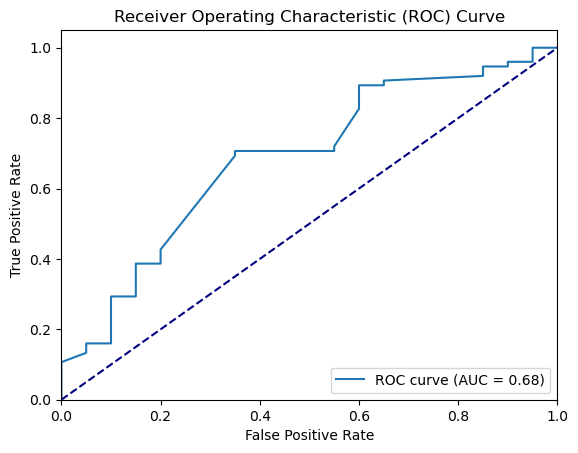

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Use the optimal preprocessing procedures (no feature selection, resample with SMOTE)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
print(y_test)
print(fpr)
print(tpr)
# Step 6: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [29]:
import shap
import matplotlib.pyplot as plt
%matplotlib qt
# shap.initjs()
explainer = shap.Explainer(clf, X_train_preprocessed)
shap_values = explainer(X_train_preprocessed)
shap_values.feature_names = selected_feature_names
# Plot SHAP Summary Plot

# plt.rcParams.update({'font.size': 12})

plt.figure()
plt.subplots_adjust(left=0.4)
# plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values)
plt.title('SHAP Summary Plot')
plt.tick_params(axis='y', labelsize=10)
plt.show()

# Plot SHAP Feature Importance Bar Chart
plt.figure()
shap.plots.bar(shap_values)
plt.title('SHAP Feature Importance Bar Chart')
plt.show()

shap.plots.waterfall(shap_values[0], max_display=14)
# Plot SHAP Force Plot for the first four samples
# plt.figure(figsize=(10, 6))
# shap.force_plot(explainer.expected_value, shap_values[10,:], X_test.iloc[0,:])
# plt.title('SHAP Force Plot for the First Four Samples')
#plt.show()

# Plot SHAP Dependence Plot for a specific feature (replace 'feature_name' with actual feature)
# feature_name = X_train_preprocessed.columns[0]  # Replace with the feature you want to plot
# plt.figure(figsize=(10, 6))
# shap.dependence_plot(feature_name, shap_values.values, X_train_preprocessed)
# plt.title(f'SHAP Dependence Plot for {feature_name}')
# plt.show()